**Convolutional Neural Network using Mel Spectograms as features**

In this notebook, the Librosa library is used to extract Mel Spectrograms (frequency against time) for each of the audio samples. These spectrograms are used as features to train models including a convolutional neural network.

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import math, random, pickle, os, operator
from tempfile import TemporaryFile

from scipy.io import wavfile
from python_speech_features import mfcc
import librosa
import librosa.display

%matplotlib inline

In [2]:
## Use GPU support with Tensorflow
# needed to prevent error from using too much gpu memory
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


Load Data
- Will use Librosa library this time to find Mel Spectograms of each audio sample

In [3]:
#Example spectogram from blues audio file
t, rate = librosa.load("D:/Datasets/genres/blues/blues.00091.wav") # returns sample rate and data (sig)
spect = librosa.feature.melspectrogram(t, rate) # convert to melspectogram
spect.shape

(128, 1293)

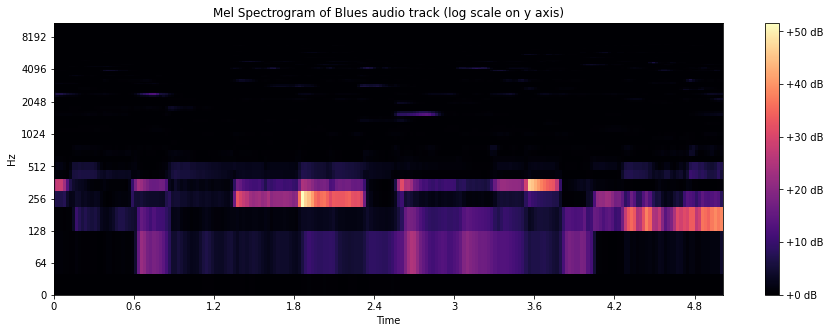

In [21]:
# Plotting Mel Spectrogram for an audio sample
def draw_specs(spects):
    for spect in spects:
        fig, ax = plt.subplots(figsize=(15,5))
        g = librosa.display.specshow(spect, x_axis='time', y_axis='log',ax=ax)
        ax.set(title="Mel Spectrogram of Blues audio track (log scale on y axis)")
        fig.colorbar(g, ax=ax, format="%+2.f dB")

draw_specs([spect])

In [15]:
# loading all spectrograms
path  = "D:/Datasets/genres/"
f = open("feat_spect.dat",'wb')

genre=0
for fold in os.listdir(path):
    genre+=1
    if genre==11:
        break
    for file in os.listdir(path+fold):
        # 29 second audio samples taken (length of shortest audio sample)
        t, rate = librosa.load(path+fold+"/"+file, duration=5) # returns sample rate and data (sig)
        spect = librosa.feature.melspectrogram(t, rate) # convert to melspectogram
        feature = (spect, genre)
        pickle.dump(feature, f)
        
#         mfcc_feat = mfcc(sig, rate, winlen=0.02, appendEnergy = False) # returns NUMFRAMES by 13 array)
#         covariance = np.cov(np.matrix.transpose(mfcc_feat))
#         mean_matrix = mfcc_feat.mean(0) # mean along column
#         feature = (mean_matrix, covariance, genre)
#         pickle.dump(feature, f)

f.close()

In [16]:
# loading data - could try converting ot pandas Dataframe instead
dataset = []
X_train = []
y_train = []
X_test = []
y_test = []
with open("feat_spect.dat", 'rb') as f:
    while True:
        try:
            dataset.append(pickle.load(f))
        except EOFError:
            f.close()
            break

# randomise dataset so that labels aren't just memorised when it encounters every example
# with the same label, and then just memorise the next label for the next set
random.shuffle(dataset)
for x in range(len(dataset)):
    if random.random() < 0.9:
        X_train.append(dataset[x][0])
        y_train.append(dataset[x][1])
    else:
        X_test.append(dataset[x][0])
        y_test.append(dataset[x][1])



In [ ]:
# Draw spectrograms for each dataset

**Data Cleaning**

In [17]:
# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = to_categorical(np.array([y-1 for y in y_train]))
y_test = to_categorical(np.array([y-1 for y in y_test]))
# Reshape for CNN
X_train = X_train.reshape(X_train.shape[0], 128, X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], 128, X_train.shape[2], 1)
# normalise
X_train = X_train / 255.0
X_test = X_test / 255.0
# convert labels to categorical?

In [18]:
X_train.shape

(917, 128, 216, 1)

In [19]:
len(dataset)

1000

**(Simpler) Logistic Regression Model**

I will first try a logistic regression model to see how well it does.

In [23]:
logModel = LogisticRegression()


CNN


In [27]:
model = Sequential()

model.add(Conv2D(64, (3,3), input_shape = X_train.shape[1:]))
# model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2,2)))

# model.add(Conv2D(64, (3,3)))
# model.add(Activation("relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # as it was 2D, dense needs 1D
# model.add(Dense(20))
# model.add(Activation("relu"))

model.add(Dense(10))
model.add(Activation('sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split = 0.1)

Epoch 1/10
26/26 [==============================] - 1s 39ms/step - loss: 0.4443 - accuracy: 0.1680 - val_loss: 0.3075 - val_accuracy: 0.2308
Epoch 2/10
26/26 [==============================] - 1s 33ms/step - loss: 0.2592 - accuracy: 0.4439 - val_loss: 0.2869 - val_accuracy: 0.3297
Epoch 3/10
26/26 [==============================] - 1s 33ms/step - loss: 0.2010 - accuracy: 0.7163 - val_loss: 0.3090 - val_accuracy: 0.3077
Epoch 4/10
26/26 [==============================] - 1s 33ms/step - loss: 0.1552 - accuracy: 0.7715 - val_loss: 0.3119 - val_accuracy: 0.3516
Epoch 5/10
26/26 [==============================] - 1s 33ms/step - loss: 0.1181 - accuracy: 0.8547 - val_loss: 0.3380 - val_accuracy: 0.3956
Epoch 6/10
26/26 [==============================] - 1s 33ms/step - loss: 0.0841 - accuracy: 0.8914 - val_loss: 0.3920 - val_accuracy: 0.3846
Epoch 7/10
26/26 [==============================] - 1s 32ms/step - loss: 0.0683 - accuracy: 0.9141 - val_loss: 0.4204 - val_accuracy: 0.3736
Epoch 8/10
26

Steps to solve overfitting:
- Randomize data
    - needed to randomize the order of labels, so that it doesn't just memorise one label, and then memorise the next one (overfitting)
- Reduce number of features as there are only 1000 training examples
    - Time of audio sample shortened to 5 seconds - resulted in slightly improved validation accuracy
- Apply dropout layers
- Reduce complexity of CNN
- Add more training examples
    - take more 5 second samples from each audio file
    - adjust how long each audio sample is (how big the 2d feature array is)